# 네이버 영화 리뷰의 감성 분석
> 한국어 형태소 분석기 khaiii를 이용하여 네이버 영화 리뷰 말뭉치(nsmc)의 감성 분석을 수행한다.

- toc: true
- badges: true
- author: 단호진
- categories: [nlp]

한글로 표기된 한국어는 어형변화가 많고 조사가 많은 역할을 한다. 조사로 말미암아 어순도 유연하게 구사할 수 있을뿐만 아니라 띄어쓰기가 내용을 전달하는데 결정적인 역할을 하지도 않는다. 이런 특징은 문장의 토큰화에 어려움을 가중시킨다. 게다가 최근 한국어 문서에서 알파벳 표기가 같이 들어오는 경우도 많은데 이를 처리하는 것도 또 다른 숙제이다. 그럼에도 다른 언어를 위하여 개발된 자연어 처리를 위한 기계학습과 심층학습의 원리는 한국어에도 마찬가지로 적용할 수 있으며, 한국어 처리를 위한 원리는 보편적으로도 유용하게 쓰일 수 있을 것이다.

이 포스트에서는 카카오에서 공개한 [khaiii 형태소 분석기](https://github.com/kakao/khaiii)를 이용하여 [네이버 영화 리뷰 말뭉치](https://github.com/e9t/nsmc)에 대한 감성 분석을 진행해 보겠다.

참고
1. 전창욱, 최태균, 조중현, 신성진, 텐서플로2와 머신러닝으로 시작하는 자연어 처리, 위키북스, 2020
2. 프랑소와 숄레, 박해선 옮김, 케라스 창시자에게 배우는 딥러닝

## 데이터

전체 영화 리뷰 데이터에서 형태소 분석을 진행한 후 훈련셋과 검정셋으로 나누어 진행하겠다. 20만 건의 리뷰가 있으며 긍정과 부정 레이블이 들어있다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('https://github.com/e9t/nsmc/raw/master/ratings.txt', delimiter='\t')
print(f'The shape of dataframe: {df.shape}')
df.head()

The shape of dataframe: (200000, 3)


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


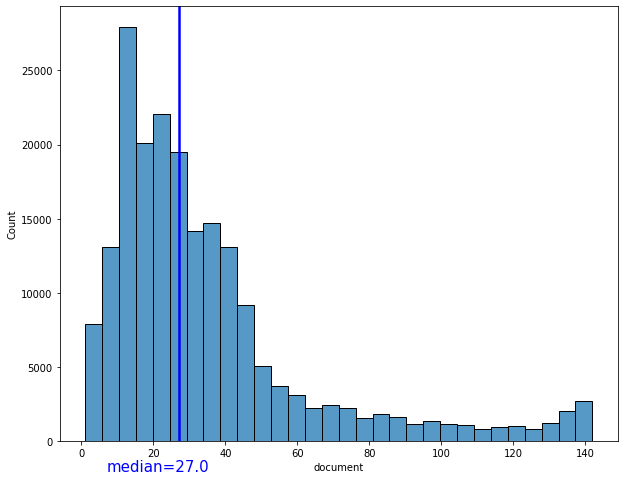

In [2]:
fig, ax = plt.subplots(figsize=(10, 8))

median = df['document'].astype(str).apply(len).median()
ax = sns.histplot(df['document'].astype(str).apply(len), bins=30, ax=ax);
ax.axvline(x=median, linewidth=2.5, color='blue')
ax.text(median - 20, -2000, f'median={median}', color='blue', fontsize=15);

리뷰 길이는 최대 140자로 제한되어 있으며 중앙값이 27로 짧은 리뷰이다.

## 형태소 분석

형태소 분석에 khaiii를 이용한다. 가장 간단하게 분석을 진행하기 위하여 알파벳이나 숫자, 기타 기호 등을 제거해 보면, 빈 리뷰가 생기는데 데이터 셋에서 이를 제거하였다. document_1 열에 정리된 리뷰가 저장된다.

In [3]:
import re

p = re.compile(r'^[\s]*$')
df = df.dropna()
df['document_1'] = (df['document'].copy()
                    .map(lambda el: re.sub(r"[^가-힣ㅏ-ㅣ\s]", " ", el))
                    .map(lambda el: re.sub(r'[\s]+', " ", el))
                   )
df['document_2'] = df['document_1'].copy().map(
    lambda el: True if p.search(el) == None else False
)
df = df[df['document_2']].drop(columns=['document_2'])
print(f'The shape of dataframe: {df.shape}')
df.head()

The shape of dataframe: (197900, 4)


,id,document,label,document_1
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,어릴때보고 지금다시봐도 재밌어요
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화


2100개의 리뷰가 제거되었다. 형태소 분석을 위한 함수를 작성하고 리뷰에 적용하여 morphemes 열에 저장하였다.

In [4]:
from khaiii import KhaiiiApi

api = KhaiiiApi()

def get_morphemes(review):
    morphemes = [w for w in api.analyze(review)]
    morphemes = [m.lex for w in morphemes for m in w.morphs]
    return list(morphemes)

df['morphemes'] = df['document_1'].apply(get_morphemes)
df.head()

,id,document,label,document_1,morphemes
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,어릴때보고 지금다시봐도 재밌어요,"[어리, ㄹ, 때, 보, 고, 지금다시, 보, 아도, 재밌, 어요]"
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,"[디자인, 을, 배우, 는, 학생, 으로, 외국, 디자이, 너, 와, 그, 들, 이..."
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,"[폴리스스토리, 시리즈, 는, 부, 터, 뉴, 까지, 버리, ㄹ께, 하나, 도, 없..."
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,"[오, 아, 연기, 가, 진, 짜, 개, 쩔, 구나, 지루, 하, ㄹ, 거, 이, ..."
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,"[안개, 자욱, 하, ㄴ, 밤하늘, 에, 뜨, 어, 있, 는, 초승달, 같, 은, 영화]"


In [5]:
morphemes = [m for r in df['morphemes'] for m in r]
morphemes = list(morphemes)
print(f'The length of morphemes: {len(morphemes)}')
morphemes[:5]

The length of morphemes: 3530533


['어리', 'ㄹ', '때', '보', '고']

약 20만개의 리뷰가 350만개의 형태소로 분석되었다. 각 리뷰는 평균적으로 형태소를 18개로 구성된다. 리뷰 길이의 중앙값은 27이었으므로 상당 수의 형태소는 길이 1 또는 2인 것을 알 수 있다. 형태소에 대하여 더 분석해 보자.

In [6]:
from collections import Counter

morphemes_freq = Counter(morphemes)
morphemes_freq = list(zip(*[(k, v) for (k, v) in morphemes_freq.items()]))
morphemes_freq = pd.DataFrame({'morpheme': morphemes_freq[0], 'n': morphemes_freq[1]})
morphemes_freq = morphemes_freq.sort_values(by='n', ascending=False)
morphemes_freq = morphemes_freq.reset_index(drop=True)
morphemes_freq = morphemes_freq.reset_index()
morphemes_freq['index'] = morphemes_freq['index'] + 1
morphemes_freq.head()

,index,morpheme,n
0,1,이,154942
1,2,하,139855
2,3,ㄴ,99839
3,4,는,89213
4,5,다,75460


In [7]:
morphemes_freq.morpheme[:100].values

array(['이', '하', 'ㄴ', '는', '다', '영화', '고', '보', '의', '가', '도', '에', '은',
       '을', '었', '지', 'ㄹ', '어', '게', '들', '았', '나', '있', '것', '를', '없',
       '아', '되', '만', '좋', '는데', '기', '로', '적', '주', '너무', '였', '여', '으로',
       '음', '정말', '네', '어요', '같', '지만', 'ㄴ다', 'ㅁ', '에서', '않', '안', '수',
       '말', '면', '아니', '과', '점', '거', '네요', '시', '만들', '그', '뭐', '연기',
       '재미있', '평점', '던', '진짜', '재밌', '나오', '잘', '이런', '겠', '라', 'ㅠ',
       '습니다', '듯', 'ㅂ니다', '이것', '생각', '싶', '왜', '와', '최고', '요', '더', '내',
       '어서', '스토리', '아서', '사람', '까지', '감동', '오', '한', '보다', '재미', 'ㅡ',
       '배우', '때', '지루'], dtype=object)

영화 리뷰인 만큼 영화라는 낱말이 많이 사용되고 있어 사실상 의미가 없는 불용어로 처리해도 되겠다. 기분을 나타내는 재미는 재미, 재밌, 재미있 등의 별개의 형태소 khaiii가 분석한 것을 알 수 있다. 과도하게 많이 사용한 형태소를 찾아 보자.

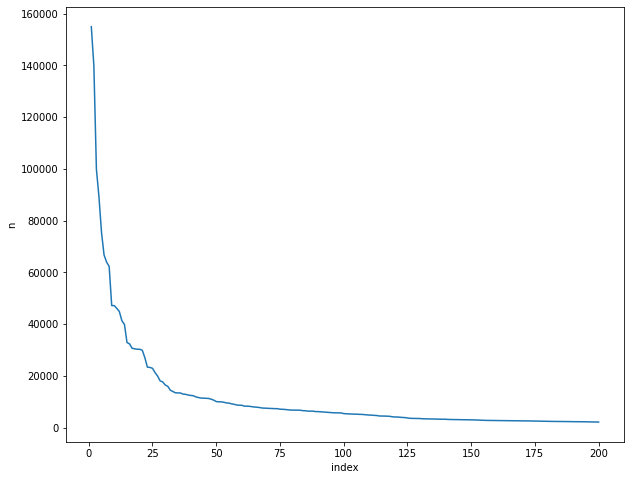

In [8]:
# import plotly.express as px

# fig = px.line(morph_freq.iloc[:200], x='index', y='n', log_y=True)
# fig.show()

fig, ax = plt.subplots(figsize=(10, 8))
# ax.set(yscale='log')
sns.lineplot(x='index', y='n', data=morphemes_freq.iloc[:200], ax=ax);

기울기가 급격하게 변하는 15000회 이상 사용된 다음 형태소는 불용어로 지정하겠다.

In [9]:
stop_words = morphemes_freq.loc[morphemes_freq.n > 15000, 'morpheme'].values
stop_words = set(stop_words)
' '.join(stop_words)

'의 다 하 만 를 아 어 고 보 은 있 을 좋 았 는 도 게 영화 들 가 이 었 없 나 는데 되 지 ㄴ ㄹ 에 것'

In [10]:
morphemes_freq['morpheme'].apply(len).value_counts()

3      35970
2      32527
4      19306
5       7683
6       2387
1       2272
7        848
8        341
9        139
10        61
11        31
12        18
13         7
14         4
17         4
16         3
15         3
21         3
24         3
18         3
28         2
30         2
22         2
31         2
129        1
36         1
35         1
39         1
133        1
29         1
26         1
23         1
20         1
47         1
Name: morpheme, dtype: int64

대부분의 형태소는 2, 3, 4글자인 것을 알 수 있다. 100자가 넘는 형태소도 존재하는데 다음과 같은 것이며 토근화를 거치며 제거될 것이다.

In [11]:
morphemes_freq[morphemes_freq['morpheme'].apply(len) > 100]

,index,morpheme,n
40688,40689,ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ...,1
93706,93707,의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리...,1


수동으로 불용어를 형태소 사전에서 제거하겠다.

In [12]:
morphemes = [m for m in morphemes if m not in stop_words]
morphemes = [(k, v) for (v, k) in enumerate(morphemes)]
morphemes = dict(morphemes)
len(morphemes)

101600

이렇게 얻어진 10만개의 형태소를 이용하여 감성 분석을 진행해 보자.

## 토큰화와 훈련·검정셋 준비

우선 불용어를 제거하고, 이 과정에서 길이가 0이된 리뷰를 제거한다.

In [13]:
df['morphemes_2'] = df['morphemes'].map(lambda el: [m for m in el if m not in stop_words])
df['morphemes_2_len'] = df['morphemes_2'].apply(len)
df = df[df['morphemes_2_len'] > 0]
df.shape

(197640, 7)

In [14]:
df = (df.drop(columns=['morphemes', 'morphemes_2_len'])
      .rename(columns={'morphemes_2': 'morphemes'}))
df.head()

,id,document,label,document_1,morphemes
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,어릴때보고 지금다시봐도 재밌어요,"[어리, 때, 지금다시, 아도, 재밌, 어요]"
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,"[디자인, 배우, 학생, 으로, 외국, 디자이, 너, 와, 그, 일, 군, 전통, ..."
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,"[폴리스스토리, 시리즈, 부, 터, 뉴, 까지, 버리, ㄹ께, 하나, 음, 최고]"
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,"[오, 연기, 진, 짜, 개, 쩔, 구나, 지루, 거, 라고, 생각, 였, 몰입, ..."
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,"[안개, 자욱, 밤하늘, 뜨, 초승달, 같]"


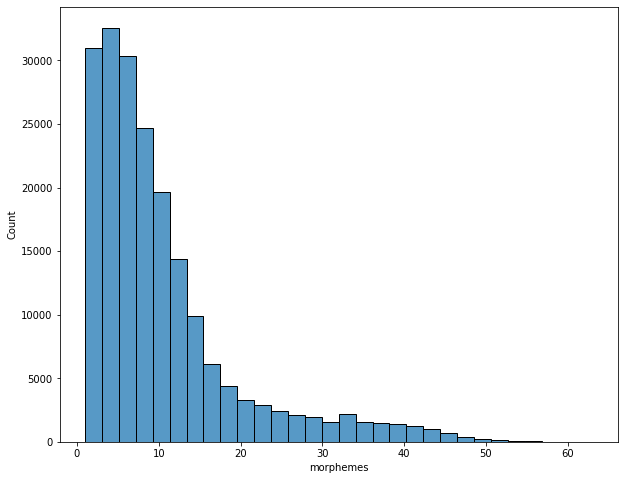

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(x=df['morphemes'].apply(len), bins=30);

리뷰의 형태소 분포는 위와 같다. 리뷰의 길이는 가변적이므로 동일한 길이의 입력으로 변환하겠다. 길이 40 이상은 절단하고 부족한 리뷰에 대해서는 패팅을 추가한다. 이를 위해서 keras의 pad_sequence 함수를 이용할 것이다.

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
maxlen = 40  # The number of morphemes per review
max_words = 80000  # 80% morphemes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.morphemes)
sequences = tokenizer.texts_to_sequences(df.morphemes)
len(tokenizer.word_index)

101600

In [18]:
wi = [(k, v) for (k, v) in tokenizer.word_index.items()]
wi = [kv for (_, kv) in zip(range(5), wi)]
wi = list(wi)
wi

[('기', 1), ('로', 2), ('적', 3), ('주', 4), ('너무', 5)]

In [19]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = df.label.values
data.shape, labels.shape

((197640, 40), (197640,))

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.3, random_state=952)

## 모델 1

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers

embedding_dim = 100

mod_1 = models.Sequential([
    layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
mod_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           8000000   
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                128032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,128,065
Trainable params: 8,128,065
Non-trainable params: 0
______________________________________________

In [22]:
mod_1.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
history = mod_1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stopping_cb]
)

Epoch 1/10
217/217 [==============================] - 5s 19ms/step - loss: 0.5980 - accuracy: 0.6558 - val_loss: 0.4060 - val_accuracy: 0.8125
Epoch 2/10
217/217 [==============================] - 4s 16ms/step - loss: 0.3921 - accuracy: 0.8288 - val_loss: 0.3911 - val_accuracy: 0.8215
Epoch 3/10
217/217 [==============================] - 4s 16ms/step - loss: 0.3617 - accuracy: 0.8464 - val_loss: 0.3780 - val_accuracy: 0.8319
Epoch 4/10
217/217 [==============================] - 4s 18ms/step - loss: 0.3349 - accuracy: 0.8599 - val_loss: 0.3825 - val_accuracy: 0.8312
Epoch 5/10
217/217 [==============================] - 4s 17ms/step - loss: 0.3166 - accuracy: 0.8697 - val_loss: 0.3928 - val_accuracy: 0.8286


In [23]:
results = mod_1.evaluate(X_test, y_test)
results

1853/1853 [==============================] - 2s 968us/step - loss: 0.3906 - accuracy: 0.8293


[0.3905869126319885, 0.8293361663818359]

정확도 82.9%를 얻었다.

# 모델 2: 합성곱 신경망

전창욱 등의 자연어 처리[1]에서 모델을 가져왔다. 다만 maxlen이나 max_words는 다르게 설정하였다.

In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.constraints import max_norm

maxlen = 40
max_words = 80000
embedding_dim = 128

inp = Input(shape=(maxlen,))
embedded_inp = layers.Embedding(max_words, embedding_dim, input_length=maxlen)(inp)
embedded_inp = layers.Dropout(0.5)(embedded_inp)
conv_3 = layers.Conv1D(100, 3, activation='relu', kernel_constraint=max_norm(3.0))(embedded_inp)
conv_3 = layers.GlobalMaxPooling1D()(conv_3)
conv_4 = layers.Conv1D(100, 4, activation='relu', kernel_constraint=max_norm(3.0))(embedded_inp)
conv_4 = layers.GlobalMaxPooling1D()(conv_4)
conv_5 = layers.Conv1D(100, 5, activation='relu', kernel_constraint=max_norm(3.0))(embedded_inp)
conv_5 = layers.GlobalMaxPooling1D()(conv_5)
out = tf.concat([conv_3, conv_4, conv_5], axis=-1)
# out = layers.Dropout(0.5)(out)
# out = layers.Dense(250, "relu")(out)
out = layers.Dense(250, "relu", kernel_constraint=max_norm(3.0))(out)
# out = layers.Dropout(0.5)(out)
# out = layers.Dense(1, "relu")(out)
out = layers.Dense(1, "relu", kernel_constraint=max_norm(3.0))(out)

mod_2 = models.Model(inp, out)
mod_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      10240000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 40, 128)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 38, 100)      38500       dropout_2[0][0]                  
______________________________________________________________________________________________

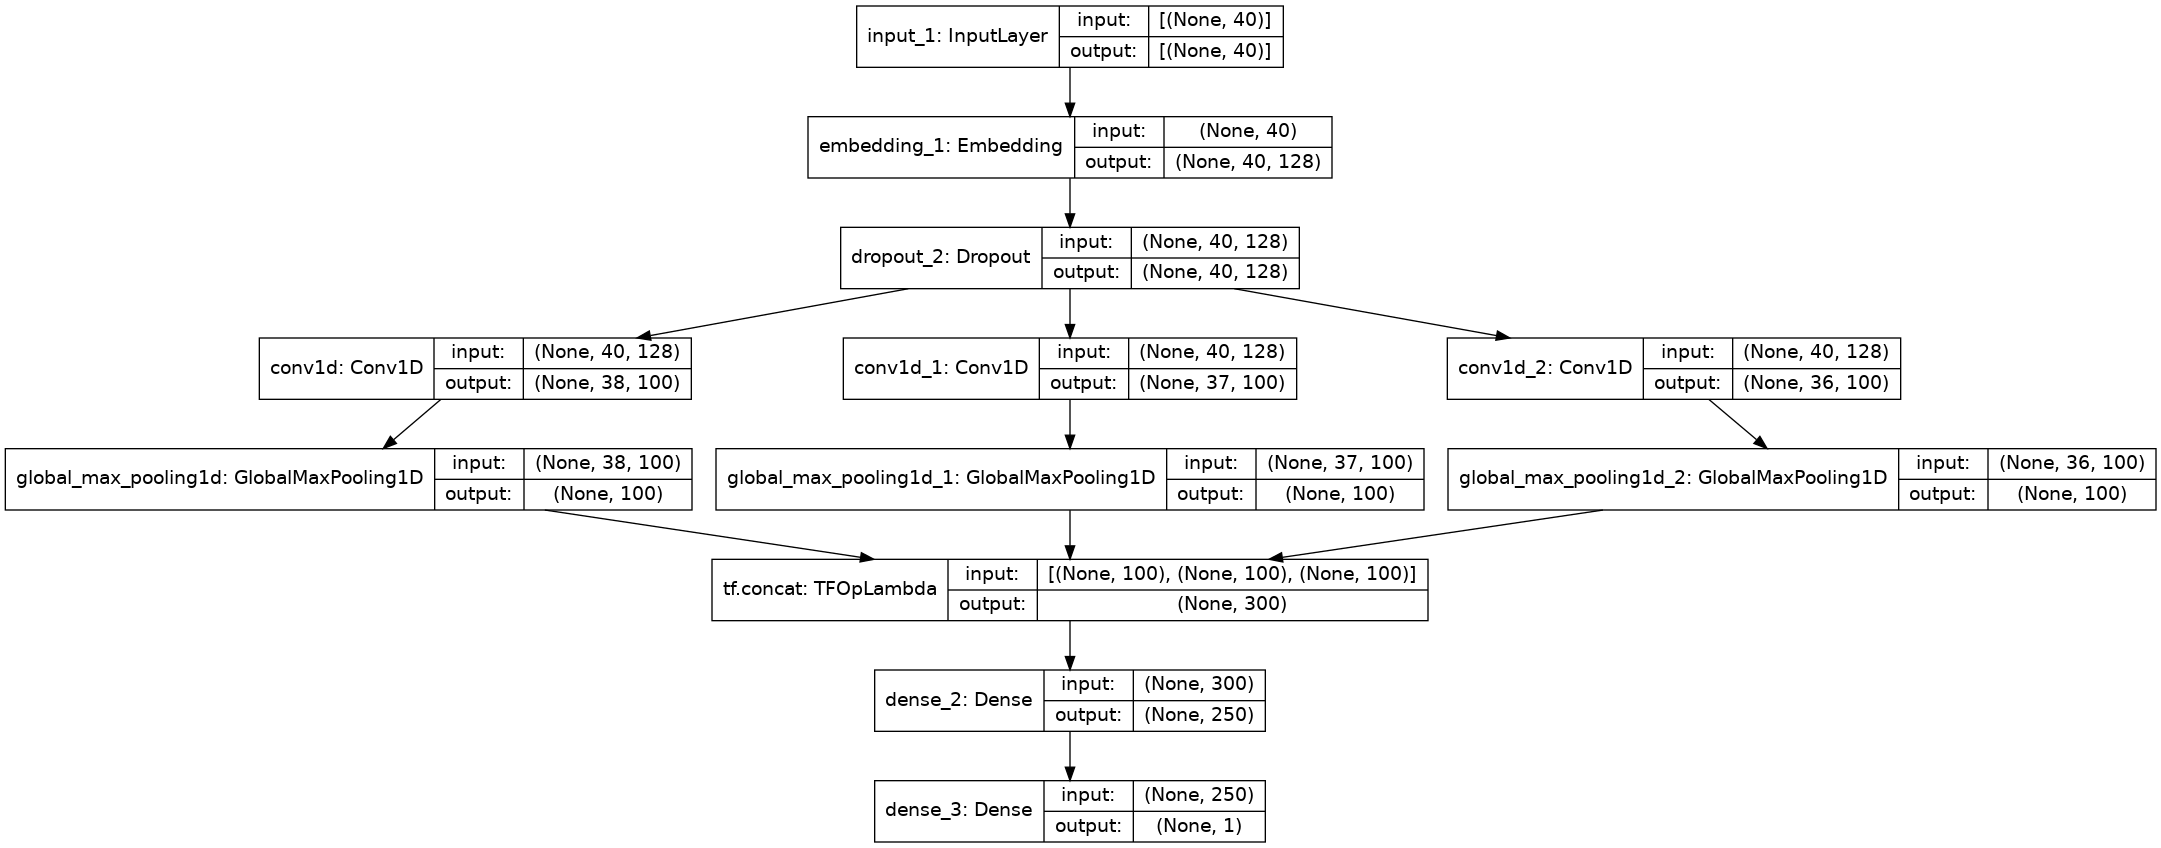

In [25]:
tf.keras.utils.plot_model(mod_2, show_shapes=True)

In [26]:
mod_2.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
history = mod_2.fit(
    X_train, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stopping_cb]
)

Epoch 1/10
217/217 [==============================] - 10s 36ms/step - loss: 0.8143 - accuracy: 0.6626 - val_loss: 0.5413 - val_accuracy: 0.7874
Epoch 2/10
217/217 [==============================] - 8s 36ms/step - loss: 0.4931 - accuracy: 0.8087 - val_loss: 0.6397 - val_accuracy: 0.7467
Epoch 3/10
217/217 [==============================] - 8s 36ms/step - loss: 0.4788 - accuracy: 0.8198 - val_loss: 0.4737 - val_accuracy: 0.8172
Epoch 4/10
217/217 [==============================] - 8s 37ms/step - loss: 0.4582 - accuracy: 0.8346 - val_loss: 0.4968 - val_accuracy: 0.8169
Epoch 5/10
217/217 [==============================] - 8s 37ms/step - loss: 0.4499 - accuracy: 0.8460 - val_loss: 0.5240 - val_accuracy: 0.8102


In [27]:
results = mod_2.evaluate(X_test, y_test)
results

1853/1853 [==============================] - 3s 2ms/step - loss: 0.5296 - accuracy: 0.8124


[0.5295822620391846, 0.812386155128479]

정확도 81.2%를 얻었다.

## 맺으며

* 한국어에 대한 형태소 분석, 토큰화, 이진 분류 모델을 구성
* 이를 이용하여 네이버 영화 리뷰에 대한 감성 분류
* khaiii 형태소 분석기로도 어느 정도의 성과를 얻음